In [1]:
import sympy as sym
sym.init_printing()

import numpy as np
from scipy.integrate import odeint
from util.plot_pairwise import pairwise

import torch
from torch.autograd import Function
import torch.nn as nn
import pyro
from pyro.nn import PyroSample
from pyro.nn import PyroModule
import pyro.distributions as dist
from pyro.infer.autoguide import AutoMultivariateNormal

from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import AdagradRMSProp
import matplotlib.pyplot as plt
%matplotlib inline

### Define the base class for ode solving with forward sensitivity

In [2]:
class OdeSolverForwardSens(object):
    def __init__(self):
        super(OdeSolverForwardSens, self).__init__()

    def _rhs(self, y, t, p):
        raise NotImplementedError
    
    def _jac_y(self, y):
        raise NotImplementedError
    
    def _jac_p(self, y):
        raise NotImplementedError
    
    def solve(self, parameters):
        return self._solve(parameters, False)

    def solve_with_sensitivities(self, parameters):
        return self._solve(parameters, True)

    def _solve(self, parameters, sensitivities):

        if sensitivities:
            self._params = parameters           
            
            def augmented_ode(y_and_dydp, t, p):
                
                y = y_and_dydp[0:self._n_states]
                dydp = y_and_dydp[self._n_states:].reshape((
                    self._n_states, self._n_params))
                dydt = self._rhs(y, t, p)
                d_dydp_dt = np.matmul(self._jac_x(y, p), dydp) + self._jac_p(y, p)
                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))            
            y0 = np.zeros(self._n_states + (self._n_states * self._n_params))
            y0[0:self._n_states] = self._y0
            result = odeint(augmented_ode, y0, self._times, (parameters,), 
                            rtol=self._rtol, atol=self._atol)
            x = result[:, 0:self._n_states]
            dx_dp = result[:, self._n_states:].reshape((
                len(times), self._n_states, self._n_params))
            return x, dx_dp
        else:
            self._params = parameters
            x = odeint(self._rhs, self._y0, self._times, (parameters,),
                            rtol=self._rtol, atol=self._atol)
            
            return x              

## The ODE velocity field

In [3]:
def r(y, t, p):
    X1, X2, X3=y
    a1, a2, alpha, k1, k2 = p
    dX1_dt = (a1/( 1 + (a2*(X3**10)) ) ) - (alpha*X1);
    dX2_dt = (k1*X1) - (alpha*X2);
    dX3_dt = (k2*X2) - (alpha*X3);
    return dX1_dt,dX2_dt,dX3_dt


## Now use `SymPy` for all expressions of Jacobians

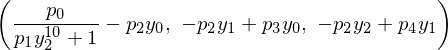

In [4]:
y, p = sym.symbols('y:3'), sym.symbols('p:5')
ydot = r(y, None, p)
ydot

In [5]:
t = sym.symbols('t')  # not used in this case.
rhs_f = sym.lambdify((y, t, p), ydot)  # EXERCISE: (y, t) + k

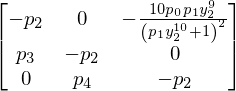

In [6]:
jac_x = sym.Matrix(ydot).jacobian(y)
jac_x

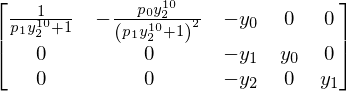

In [7]:
jac_p = sym.Matrix(ydot).jacobian(p)
jac_p

In [8]:
jac_x_f = sym.lambdify((y, p), jac_x)
jac_p_f = sym.lambdify((y, p), jac_p)

## Extend the class above and pass in the `Lambdas`

In [9]:
class GoodwinModel(OdeSolverForwardSens):
    
    def __init__(self, _rhs_f, _jac_x_f, _jac_p_f, n_states, n_params, times,
                 rtol=1e-5, atol=1e-6, y0=None):
        super(GoodwinModel, self).__init__()
               
        if y0 is None:
            self._y0 = np.array(np.zeros(n_states), dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float) 
        self._rhs_f = _rhs_f
        self._jac_x_f = _jac_x_f
        self._jac_p_f = _jac_p_f
        
        self._n_states = n_states
        self._n_params = n_params
        self._times = times
        self._T = len(times)
        self._rtol = rtol
        self._atol = atol  

        
    def _rhs(self, y, t, p):
        return self._rhs_f(y, t, p)

    def _jac_x(self, y, p):
        return self._jac_x_f(y, p)

    def _jac_p(self, y, p):
        return self._jac_p_f(y, p)

## Simulate fake data

Text(0, 0.5, 'Value')

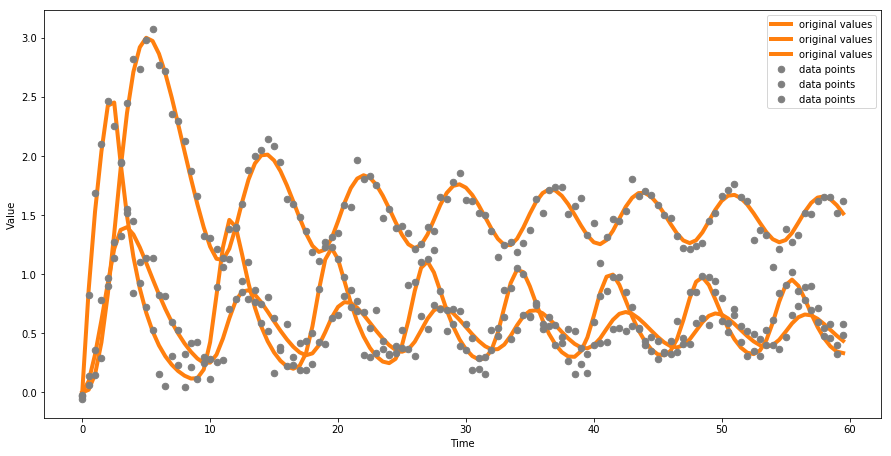

In [10]:
times = np.arange(0,60, 0.5)
gw_ode_model = GoodwinModel(rhs_f, jac_x_f, jac_p_f, 3, 5, times, 1e-5, 1e-6, [0,0,0]);
sigma=0.1
real_params = [1.97,0.15,0.53,0.46,1.49]
sol=gw_ode_model.solve(real_params)
np.random.seed(121) #np.random.seed(111)
Y=sol+np.random.randn(120,3)*sigma
plt.figure(figsize=(15, 7.5))
plt.plot(times, sol, '-', color='#ff7f0e', lw=4, label='original values')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')

## Custom ODE op

Note that we now write the custom op slightly differently to pass the ode solver object

In [11]:
class ODEop(Function):  
    @staticmethod
    def forward(ctx, params, model): 
        numpy_params = params.detach().numpy() 
        sol, Jac = model.solve_with_sensitivities(numpy_params)
        ctx.T, ctx.k, ctx.d = model._T, model._n_states, model._n_params
        ctx.save_for_backward(torch.as_tensor(Jac, dtype=params.dtype))
        return torch.as_tensor(sol, dtype=params.dtype)

    @staticmethod
    def backward(ctx, grad_output):
        T = ctx.T
        d = ctx.d
        k = ctx.k
        bJac = ctx.saved_tensors[0]
        numpy_Jac = bJac.detach().numpy().reshape((k*T,d))
        v = grad_output.detach().numpy()
        vjp = numpy_Jac.T.dot(v.reshape(k*T))
        return grad_output.new(torch.as_tensor(vjp)), None


## Define the probabilistic model

In [12]:
from pyro.nn import PyroSample
from pyro.nn import PyroModule

class GoodwinGenModel(PyroModule):
    def __init__(self, ode_model):        
        super(GoodwinGenModel, self).__init__()
        self._ode_model = ode_model
        self.ode_params = PyroSample(dist.Gamma(
            torch.tensor([2.0,2.0,2.0,2.0,2.0]),1.0).to_event(1) )      
        
    def forward(self, data): 
        
        scale = pyro.sample("scale", dist.HalfNormal(1.0))
        states = ODEop.apply(self.ode_params, self._ode_model)
        with pyro.plate("map", len(data)):

            pyro.sample("obs",
                        dist.Normal(states, scale).to_event(1),
                        obs=data)
            return states


## Define the variational approximation

In [13]:
y_torch = torch.tensor(Y,dtype=torch.float)
model = GoodwinGenModel(gw_ode_model)
guide = AutoMultivariateNormal(model)

In [14]:
pyro.set_rng_seed(121)
pyro.clear_param_store()
optim = AdagradRMSProp({"eta": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO(num_particles=1))

## Maximise the ELBO

In [15]:
def train():
    loss_trace = []
    for j in range(30000):
        loss = svi.step(y_torch)
        loss_trace.append(loss)

        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, np.mean(loss_trace[-100:])))
    return loss_trace

In [16]:
loss_graph = train()
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))


[iteration 0001] loss: 514.3626
[iteration 0501] loss: 67.3555
[iteration 1001] loss: -116.1302
[iteration 1501] loss: -211.6285
[iteration 2001] loss: -257.6240
[iteration 2501] loss: -273.2547
[iteration 3001] loss: -285.0957
[iteration 3501] loss: -282.5965
[iteration 4001] loss: -290.3048
[iteration 4501] loss: -290.3658
[iteration 5001] loss: -293.5598
[iteration 5501] loss: -292.5541
[iteration 6001] loss: -294.5683
[iteration 6501] loss: -294.2982
[iteration 7001] loss: -294.1445
[iteration 7501] loss: -296.0449
[iteration 8001] loss: -295.6449
[iteration 8501] loss: -297.9463
[iteration 9001] loss: -296.6749
[iteration 9501] loss: -296.0185
[iteration 10001] loss: -297.2748
[iteration 10501] loss: -297.5599
[iteration 11001] loss: -297.5529
[iteration 11501] loss: -298.1664
[iteration 12001] loss: -297.9659
[iteration 12501] loss: -297.1826
[iteration 13001] loss: -298.3098
[iteration 13501] loss: -298.6330
[iteration 14001] loss: -298.3626
[iteration 14501] loss: -298.4814
[it

In [31]:
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("ode_params", "scale", "obs", "_RETURN"))
vb_ppc_samples = predictive(y_torch)

In [33]:
vb_params=np.concatenate((vb_ppc_samples['ode_params'].detach().numpy().reshape((1000,5))
                          ,vb_ppc_samples['scale'].detach().numpy()),axis=1)

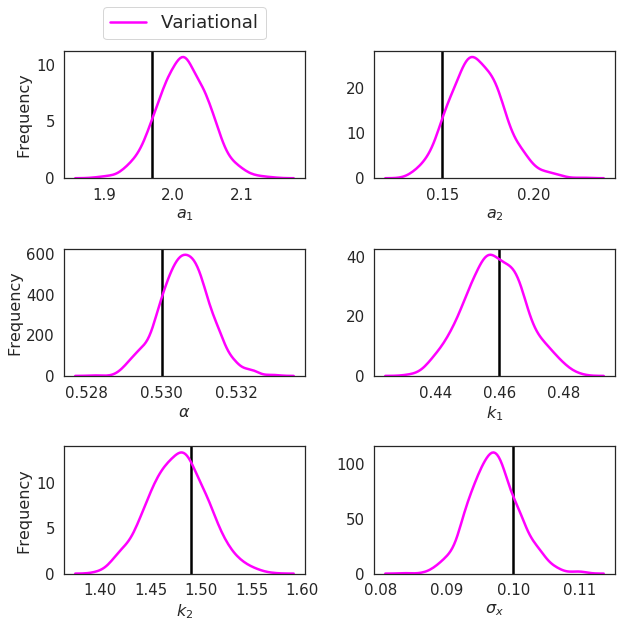

In [39]:
param_names = [r"$a_1$", r"$a_2$", r"$\alpha$", r"$k_1$", r"$k_2$", r"$\sigma_x$"]
real_params.append(0.1)
for i, p in enumerate(param_names):
        
        plt.subplot(3, 2, i+1)
        plt.axvline(real_params[i], linewidth=2.5, color='black')
        if i==0:
            sns.kdeplot(vb_params[:, i], color='magenta', linewidth = 2.5, label='Variational')
        else:
            sns.kdeplot(vb_params[:, i], linewidth = 2.5, color='magenta')
            
        if i%2==0:
            plt.ylabel('Frequency')
        plt.xlabel(param_names[i])        
        if i<1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2,fontsize=18)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()